In [49]:
import matplotlib.pyplot as plt


import numpy as np

from qiskit import QuantumCircuit
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit.primitives import Sampler
from qiskit_finance.circuit.library import LogNormalDistribution

In [50]:
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.05  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
)

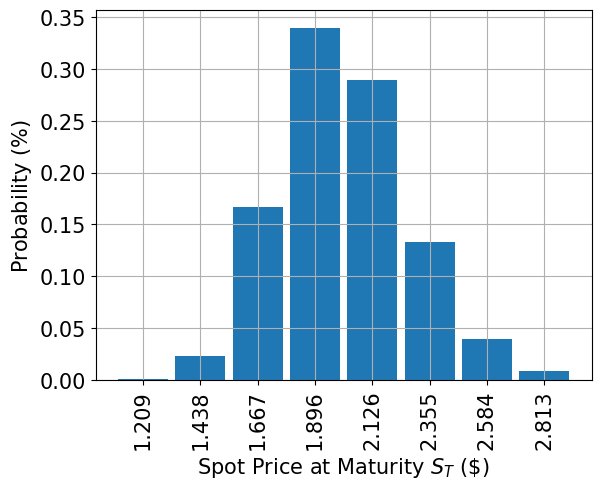

In [51]:
# plot probability distribution
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.bar(x, y, width=0.2)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.show()

In [52]:
strike_price = 1.896

# set the approximation scaling for the payoff function
c_approx = 0.25

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price
european_call_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
num_qubits = european_call_objective.num_qubits
european_call = QuantumCircuit(num_qubits)
european_call.append(uncertainty_model, range(num_uncertainty_qubits))
european_call.append(european_call_objective, range(num_qubits))

# draw the circuit
european_call.draw()

┌───────┐┌────┐
q_0: ┤0      ├┤0   ├
     │       ││    │
q_1: ┤1 P(X) ├┤1   ├
     │       ││    │
q_2: ┤2      ├┤2   ├
     └───────┘│    │
q_3: ─────────┤3 F ├
              │    │
q_4: ─────────┤4   ├
              │    │
q_5: ─────────┤5   ├
              │    │
q_6: ─────────┤6   ├
              └────┘

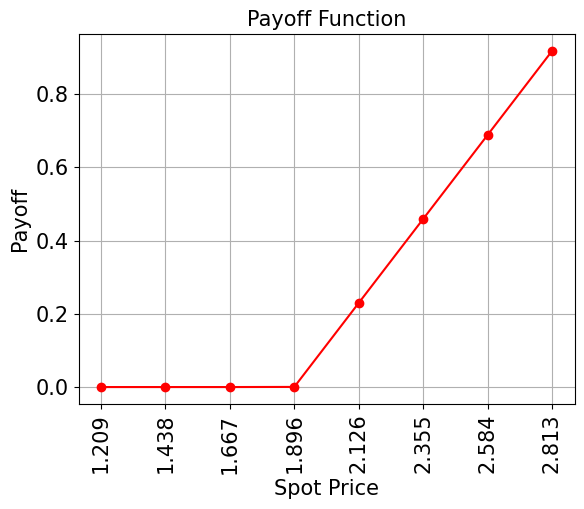

In [53]:
x = uncertainty_model.values
y = np.maximum(0, x - strike_price)
plt.plot(x, y, "ro-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("Spot Price", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [56]:
exact_value = np.dot(uncertainty_model.probabilities, y)
exact_delta = sum(uncertainty_model.probabilities[x >= strike_price])
print("exact expected value:\t%.4f" % exact_value)
print("exact delta value:   \t%.4f" % exact_delta)

exact expected value:	0.1623
exact delta value:   	0.8098


In [57]:
epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(
    state_preparation=european_call,
    objective_qubits=[3],
    post_processing=european_call_objective.post_processing,
)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler()
)

C:\Users\Rajat\AppData\Local\Temp\ipykernel_18872\374596794.py:11: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  epsilon_target=epsilon, alpha=alpha, sampler=Sampler()


In [58]:
result = ae.estimate(problem)

In [59]:
conf_int = np.array(result.confidence_interval_processed)
print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (result.estimation_processed))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.1623
Estimated value:    	0.1687
Confidence interval:	[0.1687, 0.1687]


Using qiskit_finance.applications.estimation directly

In [60]:
from qiskit_finance.applications.estimation import EuropeanCallPricing

In [61]:
european_call_pricing = EuropeanCallPricing(
    num_state_qubits=num_uncertainty_qubits,
    strike_price=strike_price,
    rescaling_factor=c_approx,
    bounds=(low, high),
    uncertainty_model=uncertainty_model,
)

In [62]:
epsilon = 0.01
alpha = 0.05

problem = european_call_pricing.to_estimation_problem()
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler()
)
result = ae.estimate(problem)

conf_int = np.array(result.confidence_interval_processed)
print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (european_call_pricing.interpret(result)))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.1623
Estimated value:    	0.1687
Confidence interval:	[0.1687, 0.1687]


C:\Users\Rajat\AppData\Local\Temp\ipykernel_18872\1811265064.py:7: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  epsilon_target=epsilon, alpha=alpha, sampler=Sampler()


**Evaluate Delta**

In [63]:
from qiskit_finance.applications.estimation import EuropeanCallDelta

european_call_delta = EuropeanCallDelta(
    num_state_qubits=num_uncertainty_qubits,
    strike_price=strike_price,
    bounds=(low, high),
    uncertainty_model=uncertainty_model,
)

In [64]:
european_call_delta._objective.decompose().draw()

┌──────┐
state_0: ┤0     ├
         │      │
state_1: ┤1     ├
         │      │
state_2: ┤2     ├
         │  cmp │
state_3: ┤3     ├
         │      │
 work_0: ┤4     ├
         │      │
 work_1: ┤5     ├
         └──────┘


To encode the payoff function, we apply a uniformly controlled Y-rotation. In this case, this operation can be efficiently implemented using 4 CNOT gates and 4 single-qubit Y-rotations. For optimization purposes, we drop the very last CNOT gate and apply it in a classical postprocessing.

In [65]:
from qiskit import QuantumCircuit
import numpy as np

# Example uncertainty model probabilities
probabilities = np.array([0.8, 0.6, 0.4, 0.2])

# State preparation vector
state_vector = np.sqrt(probabilities)

# Normalize the state vector (required for state initialization)
state_vector = state_vector / np.linalg.norm(state_vector)

# Create the quantum circuit
qc = QuantumCircuit(2)
qc.initialize(state_vector, [0, 1])

# Draw the circuit
print(qc.draw('text'))

     ┌──────────────────────────────────────────────┐
q_0: ┤0                                             ├
     │  Initialize(0.63246,0.54772,0.44721,0.31623) │
q_1: ┤1                                             ├
     └──────────────────────────────────────────────┘


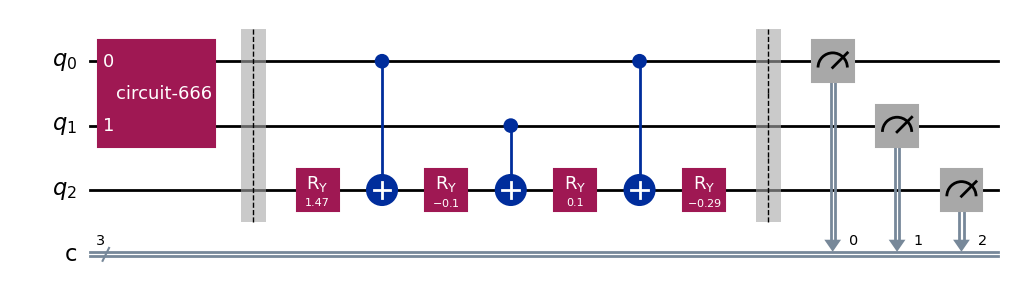

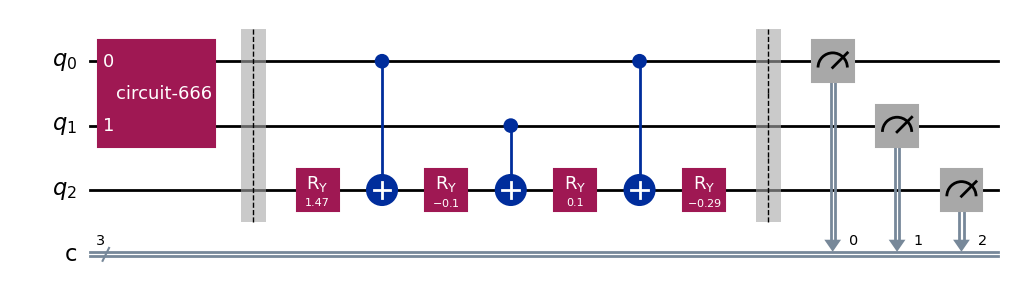

In [66]:
circ1 = QuantumCircuit(3,3)
circ1.append(qc, qargs=[0,1])
circ1.barrier()
circ1.ry(1.47,2)
circ1.cx(0,2)
circ1.ry(-0.10,2)
circ1.cx(1,2)
circ1.ry(0.10,2)
circ1.cx(0,2)
circ1.ry(-0.29,2)
#circ1.cx(1,2)
circ1.barrier()
circ1.measure(range(3), range(3))
circ1.draw('mpl')

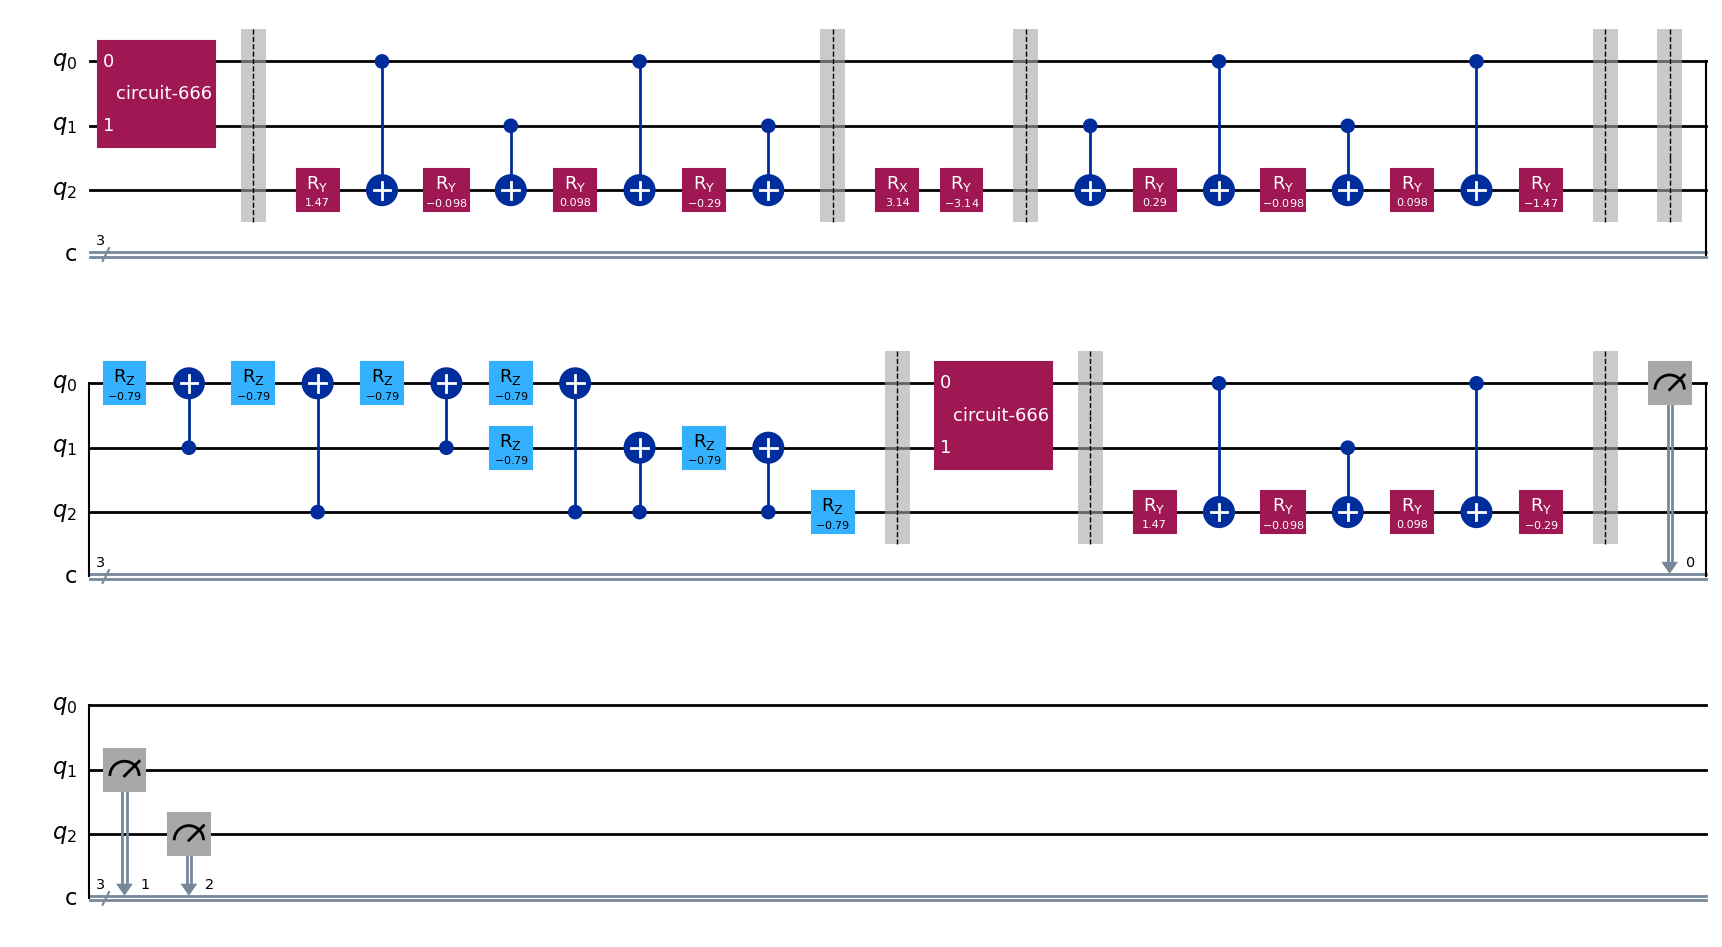

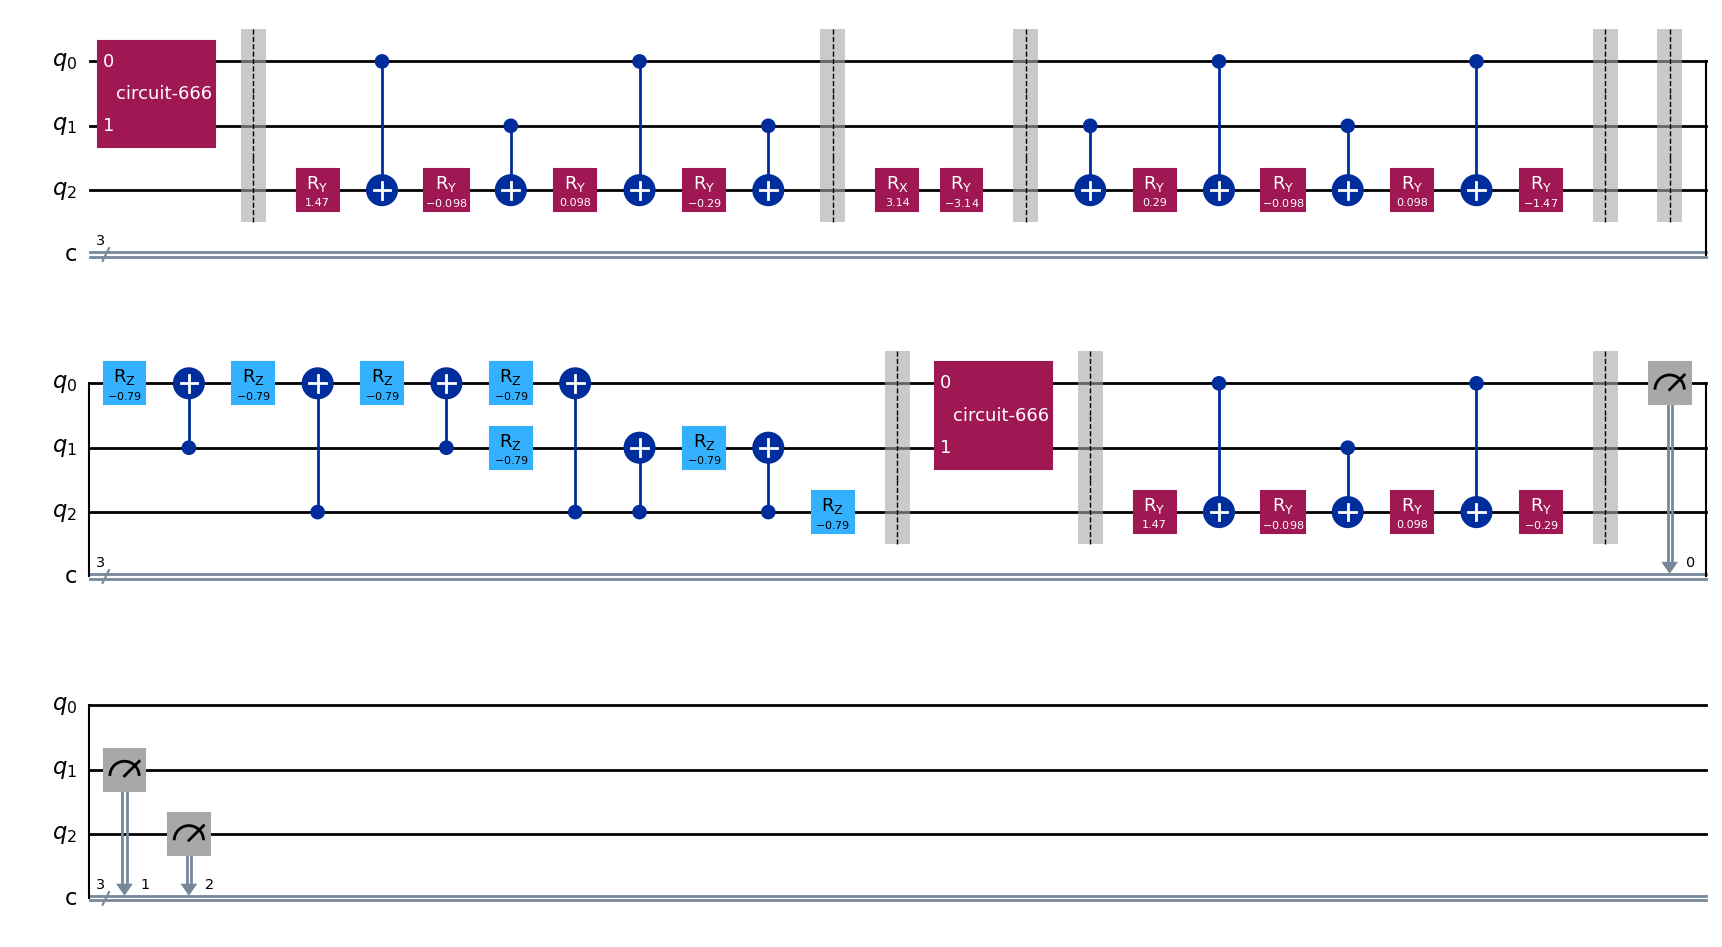

In [67]:
from qiskit import QuantumCircuit
import numpy as np

# Define the original circuit `qc` (same state preparation or isometry)
circ2 = QuantumCircuit(3, 3)

# Assuming `qc` is already defined and used earlier
# We won't append the inverse of qc to avoid the error
circ2.append(qc, qargs=[0, 1])
circ2.barrier()

# Continue with the rest of the circuit operations
circ2.ry(1.47, 2)
circ2.cx(0, 2)
circ2.ry(-9.8e-2, 2)
circ2.cx(1, 2)
circ2.ry(9.8e-2, 2)
circ2.cx(0, 2)
circ2.ry(-0.29, 2)
circ2.cx(1, 2)
circ2.barrier()

circ2.rx(3.14, 2)
circ2.ry(-3.14, 2)
circ2.barrier()

circ2.cx(1, 2)
circ2.ry(0.29, 2)
circ2.cx(0, 2)
circ2.ry(-9.8e-2, 2)
circ2.cx(1, 2)
circ2.ry(9.8e-2, 2)
circ2.cx(0, 2)
circ2.ry(-1.47, 2)
circ2.barrier()

# Remove qc.inverse() to avoid the error
# circ2.append(qc.inverse(), qargs=[0, 1])

circ2.barrier()
circ2.rz(-0.79, 0)
circ2.cx(1, 0)
circ2.rz(-0.79, 0)
circ2.cx(2, 0)
circ2.rz(-0.79, 0)
circ2.cx(1, 0)
circ2.rz(-0.79, 0)
circ2.rz(-0.79, 1)
circ2.cx(2, 0)
circ2.cx(2, 1)
circ2.rz(-0.79, 1)
circ2.cx(2, 1)
circ2.rz(-0.79, 2)
circ2.barrier()

# Append qc again
circ2.append(qc, qargs=[0, 1])
circ2.barrier()

# Continue the operations on qubit 2
circ2.ry(1.47, 2)
circ2.cx(0, 2)
circ2.ry(-9.8e-2, 2)
circ2.cx(1, 2)
circ2.ry(9.8e-2, 2)
circ2.cx(0, 2)
circ2.ry(-0.29, 2)

circ2.barrier()
circ2.measure(range(3), range(3))

# Draw the circuit
circ2.draw('mpl')


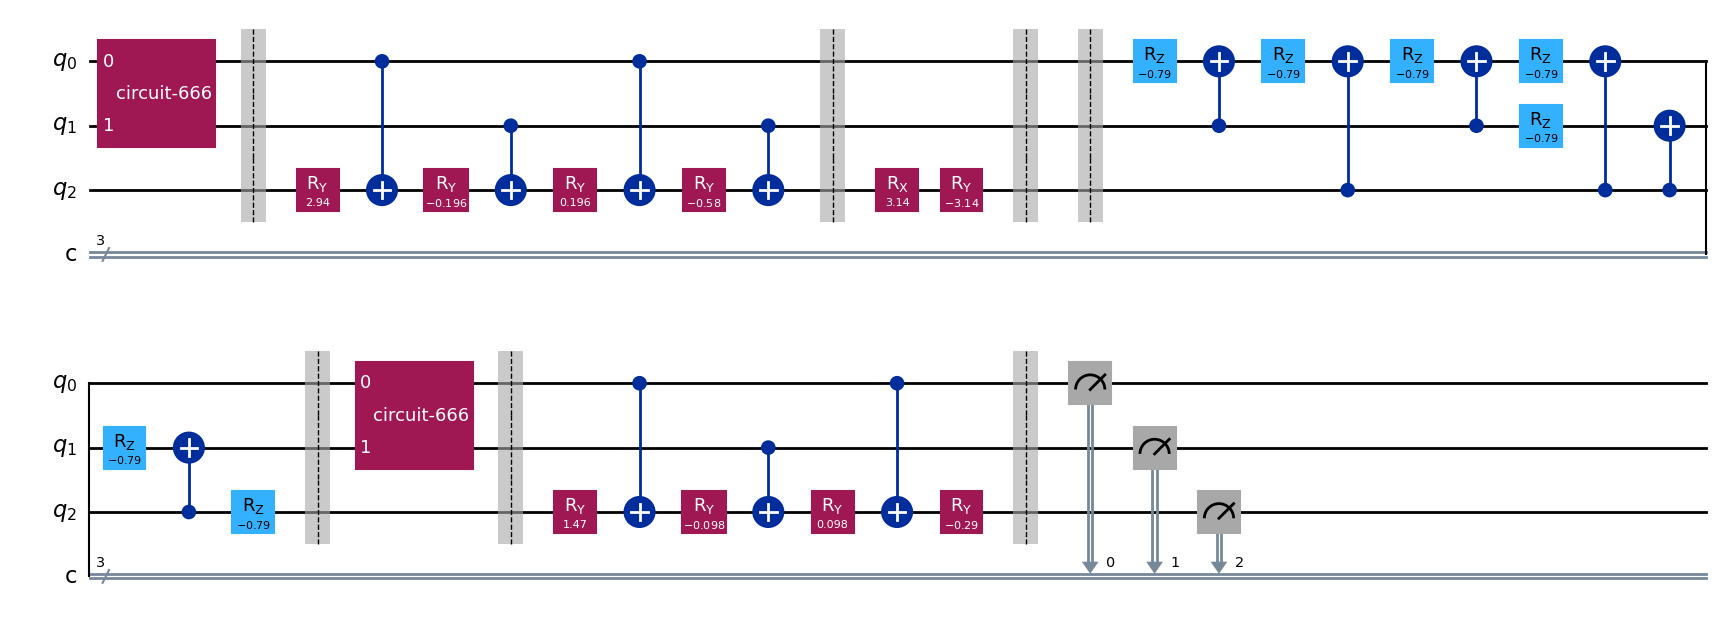

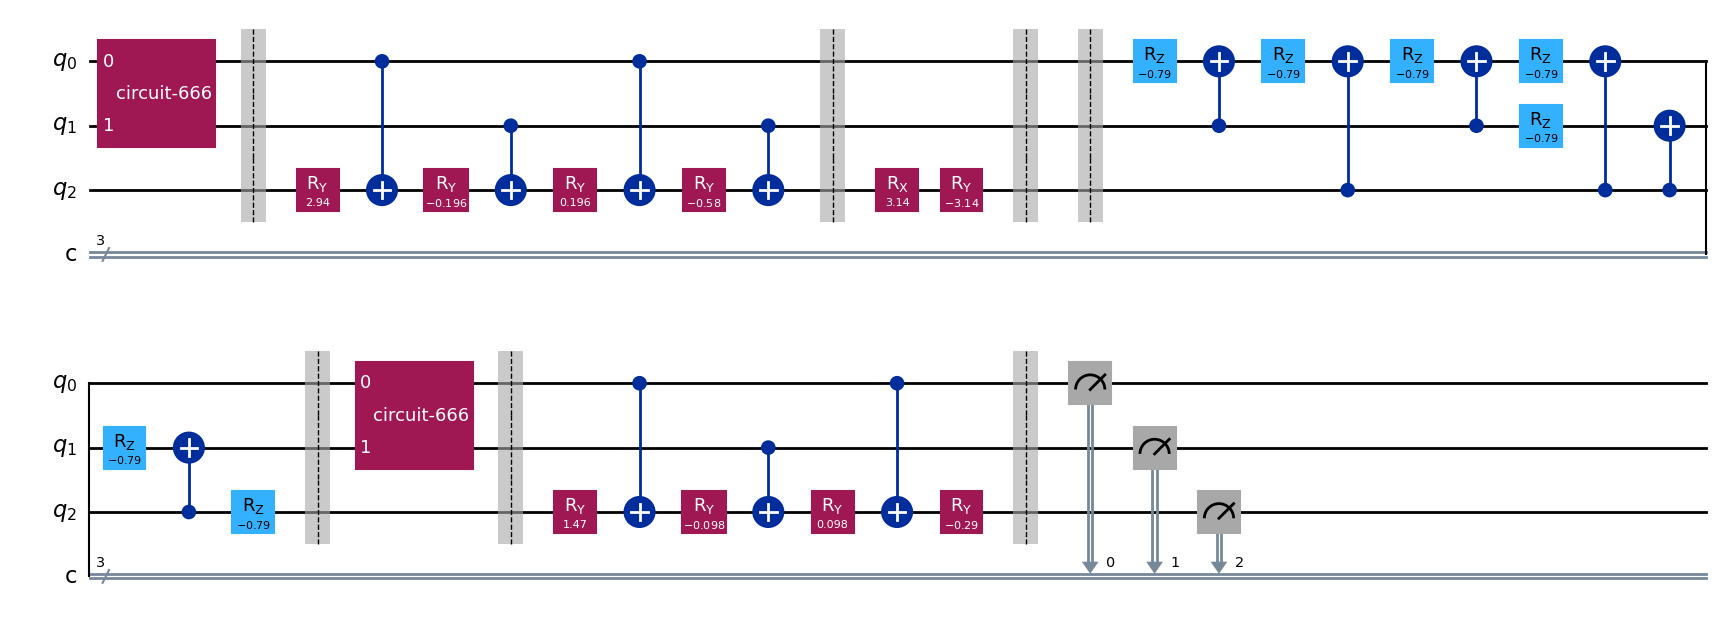

In [68]:
circ3 = QuantumCircuit(3,3)
circ3.append(qc, qargs=[0,1])
circ3.barrier()
circ3.ry(2*1.47,2)
circ3.cx(0,2)
circ3.ry(2*(-9.8e-2),2)
circ3.cx(1,2)
circ3.ry(2*(9.8e-2),2)
circ3.cx(0,2)
circ3.ry(2*(-0.29),2)
circ3.cx(1,2)
circ3.barrier()
circ3.rx(3.14,2)
circ3.ry(-3.14,2)
circ3.barrier()
#circ3.append(qc.inverse(), qargs=[0,1])
circ3.barrier()
circ3.rz(-0.79,0)
circ3.cx(1,0)
circ3.rz(-0.79,0)
circ3.cx(2,0)
circ3.rz(-0.79,0)
circ3.cx(1,0)
circ3.rz(-0.79,0)
circ3.rz(-0.79,1)
circ3.cx(2,0)
circ3.cx(2,1)
circ3.rz(-0.79,1)
circ3.cx(2,1)
circ3.rz(-0.79,2)
circ3.barrier()
circ3.append(qc, qargs=[0,1])
circ3.barrier()
circ3.ry(1.47,2)
circ3.cx(0,2)
circ3.ry(-9.8e-2,2)
circ3.cx(1,2)
circ3.ry(9.8e-2,2)
circ3.cx(0,2)
circ3.ry(-0.29,2)
#circ3.cx(1,2)
circ3.barrier()
circ3.measure(range(3), range(3))
circ3.draw('mpl')

In [69]:
from qiskit.visualization import plot_histogram

{'001': 1711, '000': 2248, '100': 1059, '010': 778, '110': 777, '111': 265, '101': 760, '011': 594}


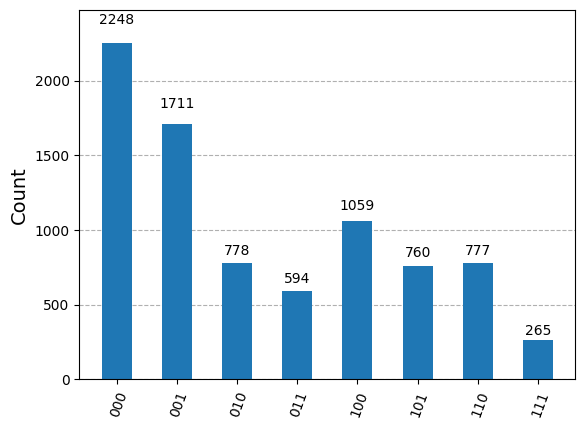

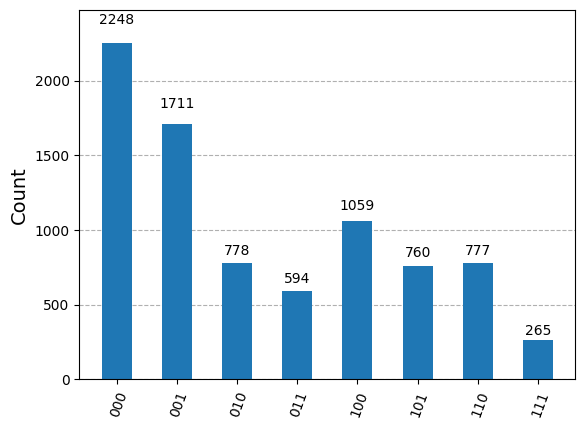

In [70]:
from qiskit import transpile 
from qiskit_aer import QasmSimulator 

backend_sim=QasmSimulator()

circ1_sim=transpile(circ1,backend_sim,optimization_level=3)
job_sim1=backend_sim.run(circ1_sim,shots=8192)
result_sim1=job_sim1.result()

counts_sim1=result_sim1.get_counts()
print(counts_sim1)

plot_histogram(counts_sim1)

{'100': 2276, '001': 732, '110': 709, '010': 984, '101': 1698, '000': 973, '011': 332, '111': 488}


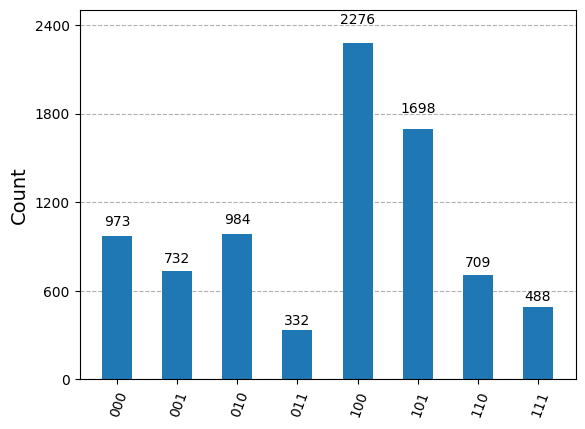

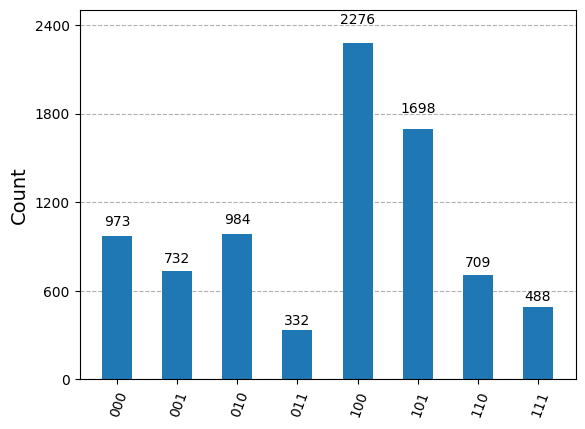

In [71]:
circ2_trans_sim = transpile(circ2, backend_sim, optimization_level=3)

#Run experiment in the simulator
job_sim2 = backend_sim.run(circ2_trans_sim, shots=8192)
result_sim2 = job_sim2.result()
counts_sim2= result_sim2.get_counts(circ2_trans_sim)
print(counts_sim2)

plot_histogram(counts_sim2)

{'000': 940, '100': 2350, '011': 335, '110': 710, '101': 1738, '010': 937, '001': 703, '111': 479}


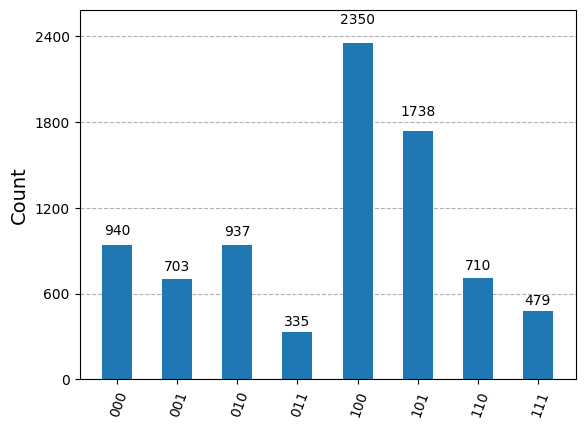

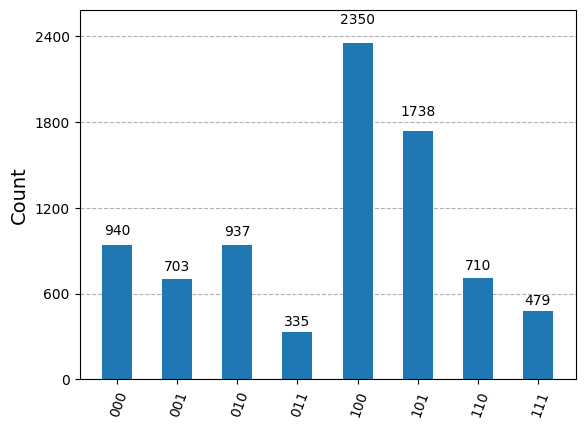

In [72]:
circ3_trans_sim = transpile(circ3, backend_sim, optimization_level=3)

#Run experiment in the simulator
job_sim3 = backend_sim.run(circ3_trans_sim, shots=8192)
result_sim3 = job_sim3.result()
counts_sim3= result_sim3.get_counts(circ3_trans_sim)
print(counts_sim3)

plot_histogram(counts_sim3)

In [73]:
from qiskit.visualization import plot_error_map 

from qiskit_ibm_runtime import QiskitRuntimeService 

from qiskit_ibm_runtime import SamplerV2 as Sampler 

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

In [41]:
service=QiskitRuntimeService()
backend=service.backend("ibm_brisbane")
print(backend.name)

ibm_brisbane


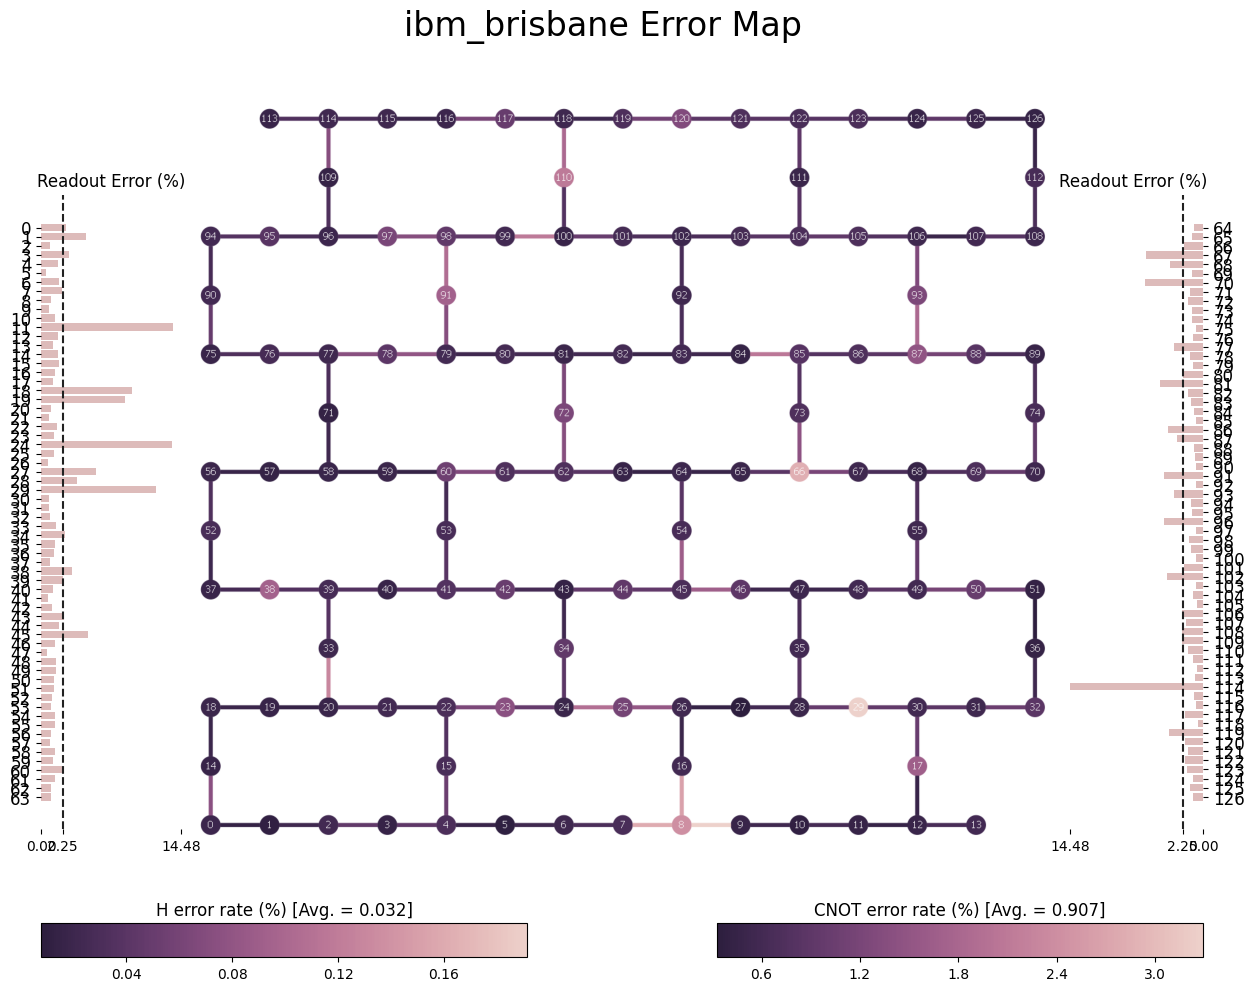

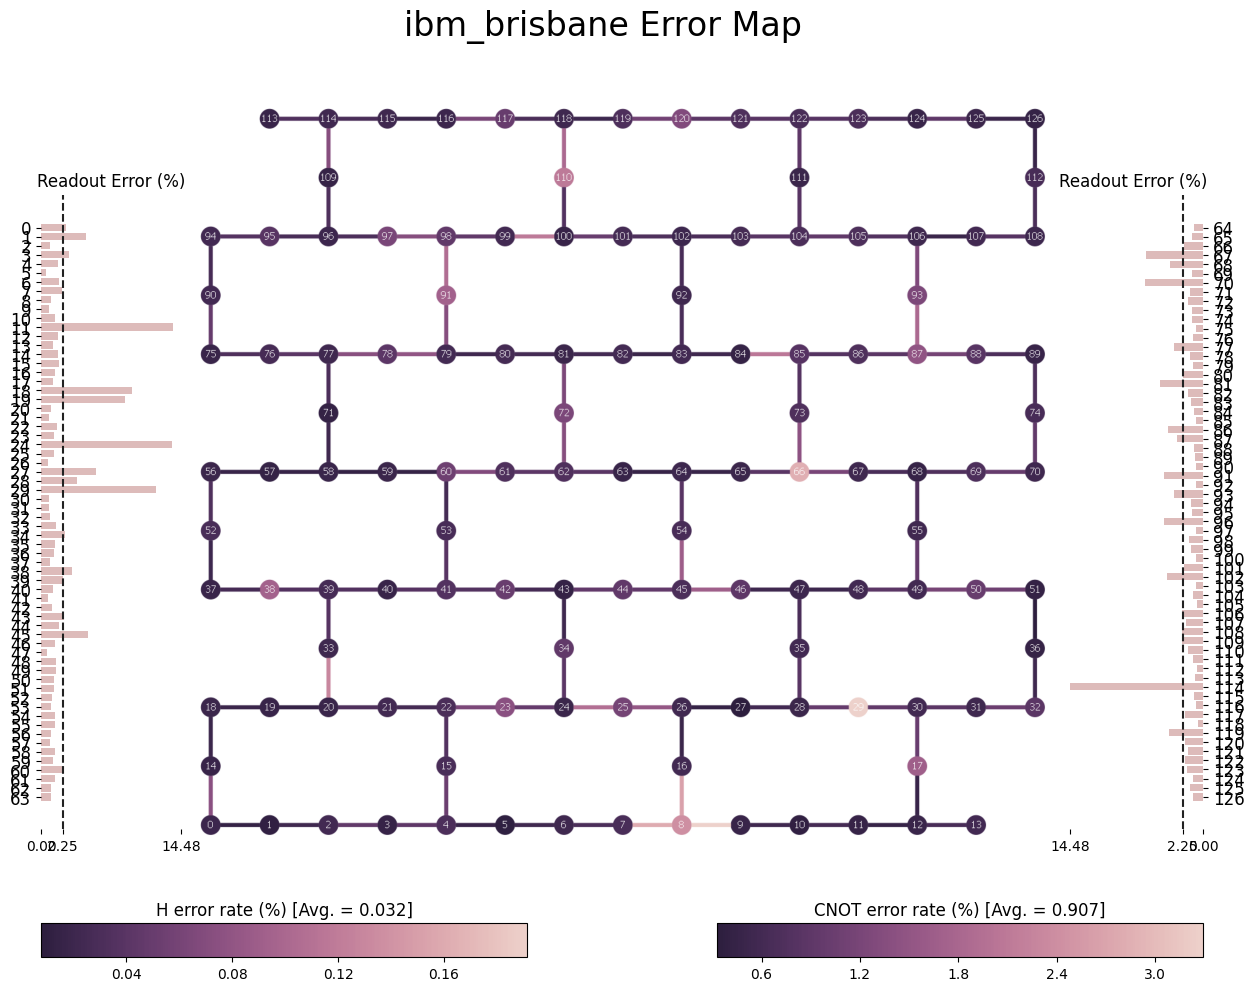

In [42]:
plot_error_map(backend)

In [74]:
pm=generate_preset_pass_manager(
    backend=backend,optimization_level=3
)
circ1_h=pm.run(circ1)
circ2_h=pm.run(circ2)
circ3_h=pm.run(circ3)



In [ ]:
sampler=Sampler(mode=backend)

job_circ1=sampler.run([circ1_h],shots=8192)
print(f"Job Id for Circuit 1: {job_circ1.job_id()}")
result_circ1=job_circ1.result()

Job Id for Circuit 1: cwckq1c2802g008fdzb0
